In [26]:
using JuMP
using Gurobi
using CSV

using DataFrames

In [27]:
using Makie, CairoMakie
Makie.inline!(true); #make sure it shows in the notebook
using LinearAlgebra: norm

In [28]:
# const GRB_ENV = Gurobi.Env(output_flag=1);

### Data importation

In [29]:
dataA = CSV.File("HW5_data//dataA.csv") |> Tables.matrix;
dataB = CSV.File("HW5_data//dataB.csv") |> Tables.matrix;

@show nA = size(dataA);
@show nB = size(dataB);

nA = size(dataA) = (1200, 3)
nB = size(dataB) = (1200, 3)


In [30]:
function getGrid(xs::Vector{Float64}, ys::Vector{Float64})
    lx, ly = length(xs), length(ys)
    lxly = lx*ly
    # res = Array{Base.promote_eltype(xs, ys), 2}(undef, lxly, 2)
    output = zeros(lxly,2);
    ind = 1
    while ind<=lxly
        @inbounds for x in xs
            output[ind] = x
            ind += 1
        end
    end
    for y in ys
        @inbounds for i=1:lx
        output[ind] = y
        ind += 1
        end
    end
    return output
end

function getGrid2(xs::Vector{Float64}, ys::Vector{Float64})
    lx, ly = length(xs), length(ys)
    lxly = lx * ly
    output = zeros(lxly, 2)  # Initialize a matrix to hold pairs of (x, y)
    ind = 1
    for x in xs
        for y in ys
            output[ind, 1] = x  # Store x value
            output[ind, 2] = y  # Store y value
            ind += 1
        end
    end
    return output
end

getGrid2 (generic function with 1 method)

In [31]:
AA = [1 2 3]
BB = [0 5 2]

min.(AA, BB)

1×3 Matrix{Int64}:
 0  2  2

In [51]:
β1 = collect(-25:0.1:75);
β2 = collect(-40:0.1:40); 
β = getGrid(β1, β2);
println(size(β));
yA  = dataA[:,3];
xA1 = dataA[:,1];
xA2 = dataA[:,2];
yB  = dataB[:,3];
xB1 = dataB[:,1];
xB2 = dataB[:,2];

lossAll = zeros(size(β,1),1);
for i = 1:size(β,1)
    lossA = (yA .- β[i,1]*xA1 - β[i,2]*xA2).^2;
    lossB = (yB .- β[i,1]*xB1 - β[i,2]*xB2).^2;
    lossAll[i] = sum(min.(lossA, lossB));
end

(801801, 2)


LoadError: MethodError: no method matching getindex(::Tuple{Int64, Int64}, ::Int64, ::Int64)

[0mClosest candidates are:
[0m  getindex(::Tuple, ::Int64)
[0m[90m   @[39m [90mBase[39m [90m[4mtuple.jl:31[24m[39m
[0m  getindex(::Tuple, ::Integer)
[0m[90m   @[39m [90mBase[39m [90m[4mtuple.jl:32[24m[39m
[0m  getindex(::Tuple, ::Real)
[0m[90m   @[39m [90mBase[39m [90m[4mdeprecated.jl:103[24m[39m
[0m  ...


In [52]:
lossAll = lossAll/(2*nA[1])

801801×1 Matrix{Float64}:
 18069.80893323299
 17991.546993854292
 17913.477915070933
 17835.556884376936
 17757.806088373527
 17680.230400705816
 17602.75802607698
 17525.375732521483
 17448.080466104882
 17370.979265473252
 17294.072130626577
 17217.359061564865
 17140.840058288115
     ⋮
 40172.2801545302
 40319.27448318001
 40465.99608210652
 40613.028730989485
 40760.38485215136
 40908.06389486945
 41055.86516455766
 41204.00752432997
 41352.49097418643
 41501.23519098077
 41650.13555333141
 41799.34842497395

# Part A: Problem Visualization

In [65]:
@show size(β[:,1])
@show size(β[:,2])
@show size(lossAll)
@show maximum(lossAll)
@show minimum(lossAll)

size(β[:, 1]) = (801801,)
size(β[:, 2]) = (801801,)
size(lossAll) = (801801, 1)
maximum(lossAll) = 41799.34842497395
minimum(lossAll) = 5.421416459079418


5.421416459079418

In [110]:
10 .^[1, 2, 3, 4]

4-element Vector{Int64}:
    10
   100
  1000
 10000

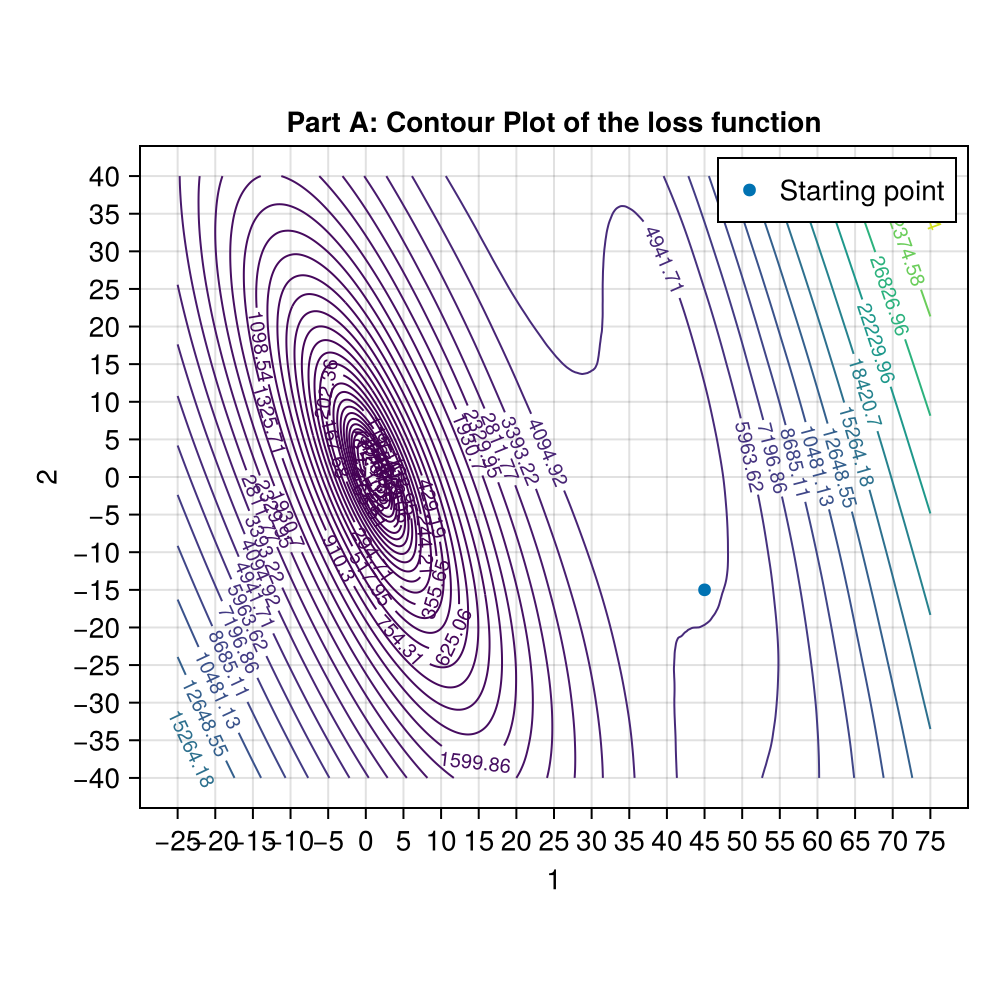

In [117]:
f_data = Figure(size = (500,500)); 
a1 = Axis(f_data[1,1], title = "Part A: Contour Plot of the loss function", xlabel = "1" , ylabel = "2", aspect = DataAspect(),
yticks = -40:5:40, xticks = -25:5:75)
c1 = contour!(a1,β[:,1], β[:,2], lossAll[:,1], levels = 10.0.^range(1, 5; length=50), labels = true)
s1 = scatter!(a1, 45, -15, label = "Starting point")
axislegend(a1)
# Colorbar(f_data[1,2],c1)
display(f_data);

In [36]:
transportation[1,:]

LoadError: UndefVarError: `transportation` not defined

# (a) : Please see the attached document.
# (b)

## b.1) Wait And See (WAS) model

In [37]:
 sum(yijs, dims = 1)

LoadError: UndefVarError: `yijs` not defined

In [38]:
set_modelWAS = [Model(Gurobi.Optimizer) for s in 1:500]; # Builds Gurobi model
set_objective = [0.0 for s in 1:500] ; 
for s in 1:500
    # Define the variables
    @variable(set_modelWAS[s], xjs[1:20, 1:500] ≥ 0, Bin); #decision to build a facility j or not (Binary).
    @variable(set_modelWAS[s], yijs[1:50,1:20, 1:500] ≥ 0) ; #amount of product sent from facility `j` to demand point `i`.
    @variable(set_modelWAS[s], zis[1:50, 1:500] ≥ 0) ; #unmet demand on demand i.
    
    # # Define the objective
    @objective(set_modelWAS[s], Min, facilities[:,1]'*xjs[:,s] + #facility setup cost
                    sum(transportation.*yijs[:,:,s]) +  #transportation cost
                    sum(zones.*zis[:,s]) + #unmet demand cost
                    sum(production[:,s].*sum(yijs[:,:,s], dims = 1))  #production cost
    )
    
    # Demand constraint 
    @constraint(set_modelWAS[s], c1, sum(yijs[:,:,s], dims = 2) .+  zis[:,s] .≥ demand[:,s])
    
    #production capacity constraint
    @constraint(set_modelWAS[s], c2, sum(yijs, dims = 1)[1,:,s]' .≤ xjs[:,s].*facilities[:,2])
end
#Note: After optimization, sum the objective value and times 0.002 (Expected value).

LoadError: Gurobi Error 10009: No Gurobi license found (user pitipatw, host BTLAB-34, hostid 10e4e0a3, cores 4)

In [39]:
for s = 1:500
optimize!(set_modelWAS[s])
    set_objective[s] = objective_value(set_modelWAS[s])
end

LoadError: UndefVarError: `set_modelWAS` not defined

In [40]:
0.002*sum(set_objective)

LoadError: MethodError: no method matching iterate(::typeof(set_objective))

[0mClosest candidates are:
[0m  iterate([91m::Base.AsyncGenerator[39m, [91m::Base.AsyncGeneratorState[39m)
[0m[90m   @[39m [90mBase[39m [90m[4masyncmap.jl:362[24m[39m
[0m  iterate([91m::Base.AsyncGenerator[39m)
[0m[90m   @[39m [90mBase[39m [90m[4masyncmap.jl:362[24m[39m
[0m  iterate([91m::Revise.LineSkippingIterator[39m)
[0m[90m   @[39m [36mRevise[39m [90mC:\Users\pitipatw\.julia\packages\Revise\uvGMC\src\[39m[90m[4mrelocatable_exprs.jl:70[24m[39m
[0m  ...


## b.2) Adaptive Stochastic Optimization (ASO) model

In [41]:
modelASO = Model(Gurobi.Optimizer); # Builds Gurobi model

# Define the variables
@variable(modelASO, xj[1:20] ≥ 0, Bin); #decision to build a facility j or not (Binary).
@variable(modelASO, yijs[1:50,1:20,1:500] ≥ 0) ; #amount of product sent from facility `j` to demand point `i` for a scenario `s`.
@variable(modelASO, zis[1:50, 1:500] ≥ 0) ; #unmet demand on demand i scenario s.

# # Define the objective
@objective(modelASO, Min, facilities[:,1]'*xj + #facility setup cost
                0.002*(
                sum(transportation.*sum(yijs, dims = 3)[:,:,1])+  #transportation cost
                sum(zones.*sum(zis, dims = 2)) +              #unmet demand cost
                sum(production.*sum(yijs, dims = 1)[1,:,:]))      #production cost
)
# Demand constraint 
@constraint(modelASO, c1[i=1:50, s = 1:500] , sum(yijs[i,:,s]) +  zis[i,s] ≥ demand[i,s])

#production capacity constraint
@constraint(modelASO, c2[s=1:500], sum(yijs[:,:,s], dims = 1)' .≤ xj.*facilities[:,2])

LoadError: Gurobi Error 10009: No Gurobi license found (user pitipatw, host BTLAB-34, hostid 10e4e0a3, cores 4)

In [42]:
# Optimize model
optimize!(modelASO);
@show is_solved_and_feasible(modelASO);
@show objective_value(modelASO);

LoadError: UndefVarError: `modelASO` not defined

## b.3) Deterministic (DTM) Model

In [43]:
modelDTM = Model(Gurobi.Optimizer);

# Define the variables
@variable(modelDTM, xj[1:20] ≥ 0, Bin); #decision to build a facility j or not (Binary).
@variable(modelDTM, yij[1:50,1:20] ≥ 0) ; #amount of product sent from facility `j` to demand point `i`
@variable(modelDTM, zis[1:50,1:500] ≥ 0) ; #unmet demand on demand i scenario s.

# # Define the objective
@objective(modelDTM, Min, facilities[:,1]'*xj +  #facility setup cost
                0.002*(sum(transportation.*yij)+  #transportation cost
                sum(zones.*sum(zis, dims = 2)) +   #unmet demand cost
                sum(sum(production, dims = 2)'.*sum(yij, dims=1))  #production cost
                )
)

# Demand constraint 
@constraint(modelDTM, c1[i=1:50, s = 1:500], sum(yij[i,:]) + zis[i,s] ≥ demand[i,s])

#production capacity constraint
@constraint(modelDTM, c2[s=1:500], sum(yij, dims = 1)' .≤ xj.*facilities[:,2])


LoadError: Gurobi Error 10009: No Gurobi license found (user pitipatw, host BTLAB-34, hostid 10e4e0a3, cores 4)

In [44]:
# Optimize model
optimize!(modelDTM);
@show is_solved_and_feasible(modelDTM);
@show objective_value(modelDTM);

LoadError: UndefVarError: `modelDTM` not defined

In [45]:
function vis_result(y::Array{VariableRef, N}; demand = demand, title = "Demand Fulfilment") where N
    f1 = Figure(size = (500,500))
    ax1 = Axis(f1[1,1]) 
    dictDemand = Dict( s => sum(demand[:,s]) for s = 1:500)
    sortScenario = sort(collect(dictDemand), by = x->x[2])
    vals = [x[2] for x in sortScenario]
    idx = [x[1] for x in sortScenario]

    barplot!(ax1, 1:500, vals)

    y = value.(y)
    if size(y,3) != 1 #
        @show "ASO"
        dictY = Dict( s => sum(y[:,:,s]) for s = 1:500) 
    else 
        @show "DTM"
        dictY = Dict( s => sum(y) for s = 1:500) 
    end
        yvals = [dictY[id] for id in idx]

    barplot!(ax1, 1:500, yvals)
    return f1
end

function vis_result(y::Vector{Model}; demand = demand, title = "Demand Fulfilment")
    f1 = Figure(size = (500,500))
    ax1 = Axis(f1[1,1]) 
    dictDemand = Dict( s => sum(demand[:,s]) for s = 1:500)
    sortScenario = sort(collect(dictDemand), by = x->x[2])
    vals = [x[2] for x in sortScenario]
    idx = [x[1] for x in sortScenario]

    barplot!(ax1, 1:500, vals)

    total_y = zeros(500,1)

    for s in 1:500
        # @show y[s][:yijs]
        total_y[s]  = sum(value.(y[s][:yijs]))
    end

    dictY = Dict( s => total_y[s] for s = 1:500) 

    yvals = [dictY[id] for id in idx]

    barplot!(ax1, 1:500, yvals)
    return f1
end


vis_result (generic function with 2 methods)

In [46]:
vis_result(values(modelASO[:yijs]))

LoadError: UndefVarError: `modelASO` not defined

In [47]:
vis_result(values(modelDTM[:yij]))

LoadError: UndefVarError: `modelDTM` not defined

In [48]:
vis_result(values(set_modelWAS))

LoadError: UndefVarError: `set_modelWAS` not defined

In [49]:
total_y = zeros(500,1)

for s in 1:500
        # @show y[s][:yijs]
        total_y[s]  = sum(value.(set_modelWAS[s][:yijs]))
    end

LoadError: UndefVarError: `set_modelWAS` not defined

In [50]:
set_modelWAS[54]

LoadError: UndefVarError: `set_modelWAS` not defined